In [59]:
import numpy as np
from scipy.spatial import distance
import dlc_tda_ppross as dlcp
import embedding
import matplotlib.pyplot as plt
from numba import jit
import seaborn as sns


def get_manif(case, dim):
    



    m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
    m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2
    tail_x=dlcp.retrivedata(case, 'tail')
    tail_y=dlcp.retrivedata(case, 'tail.1')

    ang_bod=np.array(dlcp.angs(tail_x, tail_y, m_head_x, m_head_y))
    d_body=dlcp.smooth_diff(ang_bod)



    #dim=25
    #Shuffling
    #d_body=np.random.shuffle(d_body)
    #np.random.shuffle(d_body)



    #SVD Embedding
    embeded=embedding.l_embed(d_body,100,1)
    manif=embedding.svd_lags(embeded, dim)

    return manif

def get_target(case, dim):


    m_head_x=(dlcp.retrivedata(case,'headR')+dlcp.retrivedata(case, 'headL'))/2        #get bodypart signals
    m_head_y=(dlcp.retrivedata(case, 'headR.1')+dlcp.retrivedata(case, 'headL.1'))/2

    cos_head_ang=dlcp.cos_thet_head(dlcp.retrivedata(case,'tail'),dlcp.retrivedata(case,'tail.1'),
     m_head_x,m_head_y,dlcp.retrivedata(case,'headR'),dlcp.retrivedata(case,'headR.1'),dlcp.retrivedata(case,'headL'),
     dlcp.retrivedata(case,'headL.1'))


    embeded=embedding.l_embed(cos_head_ang,100,1)
    manif=embedding.svd_lags(embeded, dim)
    return manif




@jit(nopython=True)
def find_ind(inp, l):
    j=0
    for i in inp:
        if i==l:
            return float(j)
        else:
            j+=1


@jit(nopython=True)
def euc_dist(p1, v2): #p1: point, v1:vector

    dist_pt=np.zeros(len(p1))
    dist_vct=np.zeros(len(v2))
    k=0
    for j in v2:
        for i in range(len(p1)):
            dist_pt[i]=(p1[i]-j[i])**2
        dist_vct[k]=np.sqrt(np.sum(dist_pt))
        k+=1

    return dist_vct

@jit(nopython=True)
def simp_nnb(inp,t_point):
    dist1=euc_dist(inp[t_point], inp)
    dist2=np.sort(dist1)

    near_n_ind=np.zeros_like(dist2[1:])
    k=0
    for dis in dist2[1:]:    
        near_n_ind[k]=find_ind(dist1, dis)
        k+=1
    return   near_n_ind, dist2[1:]


@jit(nopython=True)
def euc_dist1(p1,p2): #p1 and p2 are n-dimentiona points
    dist_pt=np.zeros(len(p1))
    for i in range(len(p1)):
        dist_pt[i]=(p1[i]-p2[i])**2
    return np.sqrt(np.sum(dist_pt))



@jit(nopython=True)
def scoring(preds, actual):
    """The coefficient R^2 is defined as (1 - u/v), where u is the regression
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
    sum of squares ((y_true - y_true.mean()) ** 2).sum(). Best possible
    score is 1.0, lower values are worse.
    Parameters
    ----------
    preds : 1d array
        Predicted values.
    actual : 1d array
        Actual values from the testing set.
    Returns
    -------
    cc : float
        Returns the coefficient of determiniation between preds and actual.
    """

    u = np.square(actual - preds).sum()
    v = np.square(actual - actual.mean()).sum()
    r2 = 1 - u/v

    return r2


@jit(nopython=True)
def correlation_scoring(targt, predict, forecast_l):



    corrs=np.zeros(targt.shape[1])
    forc_l=len(predict[0])

    m=0
    for i in range(targt.shape[1]):
        corrs[m]=np.corrcoef(targt[:forecast_l,i],predict[:forecast_l,i])[0,1]
        m=m+1




    return corrs





@jit(nopython=True)
def CCM(cause, targt, forecast_l):

    t_points=np.arange(forecast_l) #should creat a list of time points.
    dim=cause.shape[1]
    recons=np.zeros((forecast_l,cause.shape[1]))    
    m=0

    for t_point in t_points:


        #calculate the weights
        ind_in ,dist=simp_nnb(cause,t_point)

        wi=np.zeros(dim+1)
        k=0
        for i in ind_in[:dim+1].astype(np.int64):
            wi[k]=np.exp(-dist[i-1]/dist[0])
            k+=1
        s_wi=np.sum(wi)



        #make predictions 
    

        #i=i+inp_t_p #for prediction after the training fraction
        #ind_in ,_=simp_nnb(targt,t_point)

        y_hat=np.array([0.0]*targt.shape[1])
        for j in range(dim+1):
            y_hat+=((wi[j]*targt[int(ind_in[j])])/s_wi)
        recons[t_point]=y_hat
        m=m+1


    
    scr=scoring(recons, targt[:forecast_l,:])
    
    return recons, scr

In [60]:
#The Head To body

In [77]:

dim=7

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LID21.csv'
cause=get_target(case, dim)[::10] #downsampling is essential

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LID21.csv'
targt=get_manif(case, dim)[::10]

forecast_l=500

prediction, score=CCM(cause, targt, forecast_l)


print(score)




0.325383993047908


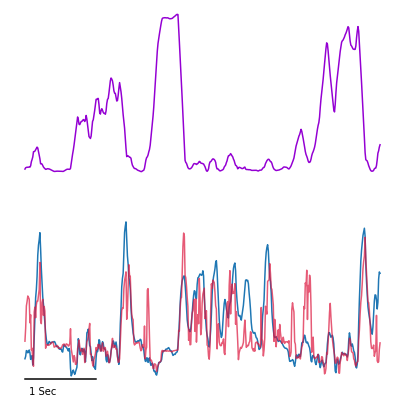

In [85]:


survey_dim=0

ti=np.linspace(0,forecast_l,forecast_l)*(1/50)

fig1 = plt.figure(figsize=(7, 7))
ax1=fig1.add_subplot(211)
ax1.plot(ti,cause[:forecast_l,survey_dim] , color='darkviolet', label='Cause')
#ax1.legend(frameon=False)

plt.xticks([])
plt.yticks([])



ax2=fig1.add_subplot(212)
ax2.plot(ti,targt[:forecast_l,survey_dim], label='Effect')
ax2.plot(ti,prediction[:forecast_l,survey_dim], color='crimson', label='Reconstruction',alpha=0.7)

#ax2.legend(frameon=False, bbox_to_anchor=(0.2, 0.8) )
#ax2.set_xlabel('Time(sec)')
#ax2.set_ylabel('Dim-1')
ax2.plot([0, 2], [-10, -10], color='black')
ax2.text(0.1, -15, '1 Sec')

sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.savefig('example_ccm.svg')

(0.0, 6.0)

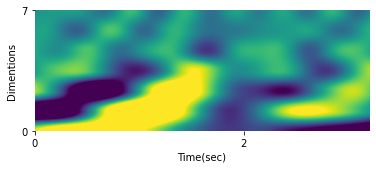

In [63]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LES3.csv'
vis_manif=get_target(case, dim).T #downsampling is essential


ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(vis_manif[:2000,:],vmin=-1.8, vmax=1.8, aspect=12)





plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')



sns.despine(top=True, right=True, left=True, bottom=True)



ti_ticks=ti*(1/50) #note that the data has been down sampled
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])
#plt.xticks([])

plt.xlim(0,200)
plt.ylim(0,6)


(0.0, 6.0)

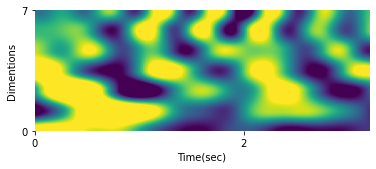

In [64]:
case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LES3.csv'
vis_manif=get_manif(case, dim).T #downsampling is essential


ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(vis_manif[:2000,:],vmin=-3.8, vmax=2.8, aspect=12)





plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')



sns.despine(top=True, right=True, left=True, bottom=True)



ti_ticks=ti*(1/50) #note that the data has been down sampled
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])
#plt.xticks([])

plt.xlim(0,200)
plt.ylim(0,6)


In [65]:
np.sum(vis_manif[:,2], axis=0)
vis_manif[:,2]

array([ 4.72418263, -4.46056498,  0.74005113,  4.92788473,  1.99459746,
        0.56215759, -1.36366032])

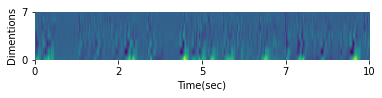

In [66]:
ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(prediction.T[:200,:], aspect=12)


4

plt.xlim(0,200)
plt.ylim(0,6)

ti_ticks=ti*(1/50)
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])



plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')


sns.despine(top=True, right=True, left=True, bottom=True)

In [67]:
#The body to head

In [68]:

dim=7

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LES1.csv'
cause=get_manif(case, dim)[::10] #downsampling is essential

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LES3.csv'
targt=get_target(case, dim)[::10]

forecast_l=200

prediction, score=CCM(cause, targt, forecast_l)


print(score)



0.035710133132614064


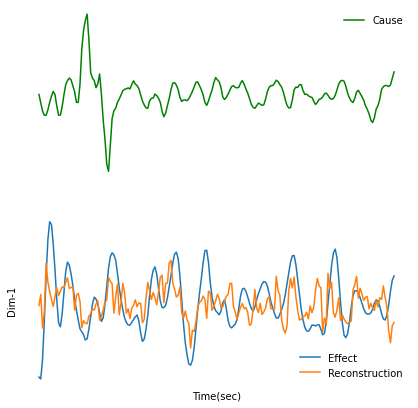

In [69]:
survey_dim=1

ti=np.linspace(0,forecast_l,forecast_l)*(1/50)

fig1 = plt.figure(figsize=(7, 7))
ax1=fig1.add_subplot(211)
ax1.plot(ti,cause[:forecast_l,survey_dim], label='Cause', color='green')
ax1.legend(frameon=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])


ax2=fig1.add_subplot(212)
ax2.plot(ti,targt[:forecast_l,survey_dim], label='Effect')
ax2.plot(ti,prediction[:forecast_l,survey_dim], label='Reconstruction')

ax2.legend(frameon=False)
ax2.set_xlabel('Time(sec)')
ax2.set_ylabel('Dim-1')

sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])

plt.savefig('ccm_ex.svg')

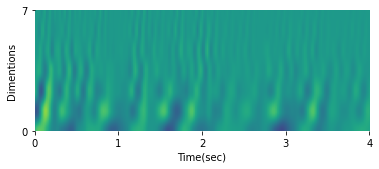

In [70]:
ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(targt.T[:200,:], aspect=12)




plt.xlim(0,200)
plt.ylim(0,6)

ti_ticks=ti*(1/50)
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])


plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')


sns.despine(top=True, right=True, left=True, bottom=True)

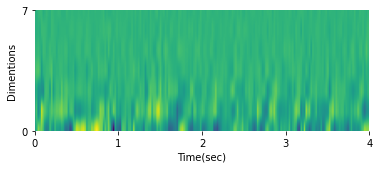

In [71]:
ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(prediction.T[:200,:], aspect=12)




plt.xlim(0,200)
plt.ylim(0,6)

ti_ticks=ti*(1/50)
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])


plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')


sns.despine(top=True, right=True, left=True, bottom=True)

In [72]:
#Shuffle

In [87]:

dim=7

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/LES3.csv'
cause=get_manif(case, dim)[::10] #downsampling is essential

case='/home/morteza/dlc_projects/Analysis/Currencodes/TDA/Visualization/pilot_data/SHM21.csv'
targt=get_target(case, dim)[::10]

forecast_l=200

prediction, score=CCM(cause, targt, forecast_l)


print(score)


-0.10371243702776667


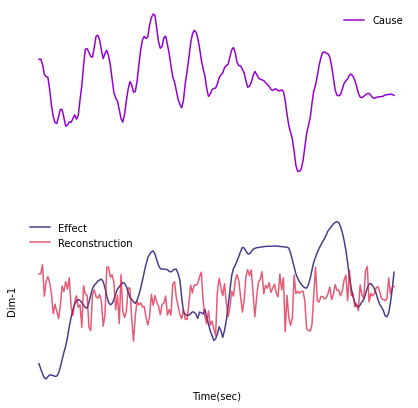

In [90]:
survey_dim=0

ti=np.linspace(0,forecast_l,forecast_l)*(1/50)

fig1 = plt.figure(figsize=(7, 7))
ax1=fig1.add_subplot(211)
ax1.plot(ti,cause[:forecast_l,survey_dim], label='Cause', color='darkviolet')
ax1.legend(frameon=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])



ax2=fig1.add_subplot(212)
ax2.plot(ti,targt[:forecast_l,survey_dim], color='darkslateblue', label='Effect')
ax2.plot(ti,prediction[:forecast_l,survey_dim], color='crimson', label='Reconstruction', alpha=0.7)

ax2.legend(frameon=False)
ax2.set_xlabel('Time(sec)')
ax2.set_ylabel('Dim-1')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])

plt.savefig('CCM_ex_scrm.svg')

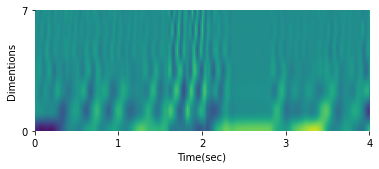

In [75]:
ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(targt.T[:200,:], aspect=12)




plt.xlim(0,200)
plt.ylim(0,6)

ti_ticks=ti*(1/50)
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])


plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')


sns.despine(top=True, right=True, left=True, bottom=True)

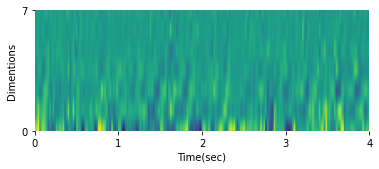

In [76]:
ti=np.linspace(0,forecast_l,5)



fig=plt.figure()
plt.imshow(prediction.T[:200,:], aspect=12)




plt.xlim(0,200)
plt.ylim(0,6)

ti_ticks=ti*(1/50)
plt.xticks(ti,ti_ticks.astype(int))
plt.yticks([0,6], ['0', '7'])


plt.xlabel('Time(sec)')
plt.ylabel('Dimentions')


sns.despine(top=True, right=True, left=True, bottom=True)